In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.gray();
from keras.datasets import cifar10
from keras.layers import Dense, Conv2D, Flatten, Dropout, SpatialDropout2D
from keras.optimizers import SGD
from keras.models import Sequential
from keras.models import load_model
import numpy as np
from skimage.data import camera, chelsea, astronaut
from skimage.exposure import equalize_hist, equalize_adapthist
from scipy.spatial.distance import euclidean
from scipy.stats import wasserstein_distance
import skimage.filters
from skimage.color import rgb2gray
from skimage.transform import resize 
from transforms import unsharp_mask, original #sharpened = original + (original − blurred) × amount
from functools import partial
from utils import display_transforms
import warnings
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
imsize = 32
(cifar_train, cifar_train_labels), (cifar_test, cifar_test_labels) = cifar10.load_data()
cifar_train, cifar_test = rgb2gray(cifar_train), rgb2gray(cifar_test)
test_images = [resize(rgb2gray(im), (imsize, imsize)) for im in (camera(), chelsea(), astronaut())]

ops = {
    'Original':original,
    'Histogram Equalization': equalize_hist,
    'Adaptive Histogram Equalization': partial(equalize_adapthist, kernel_size=imsize//4),
    'Unsharp mask': partial(unsharp_mask, amount=1.0)
}

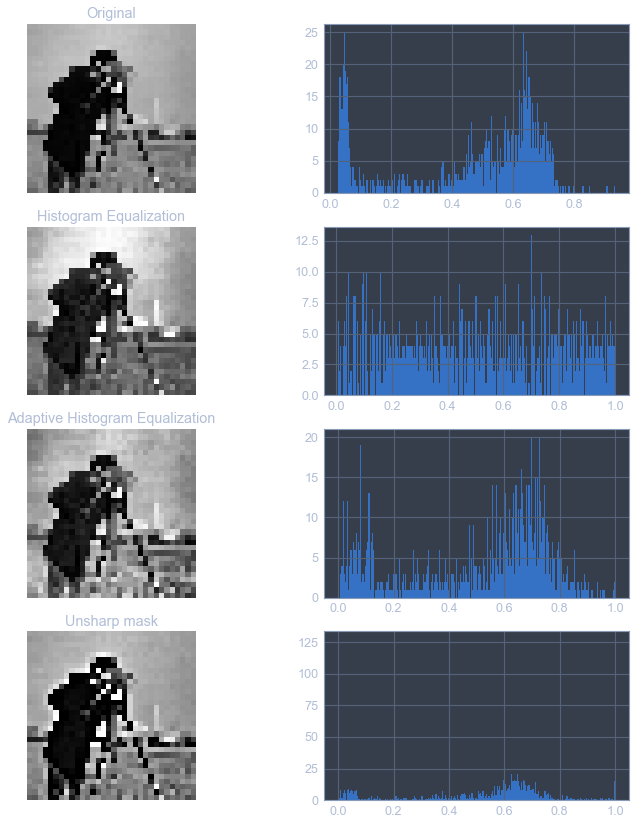

In [3]:
display_transforms(test_images[0], ops)

In [4]:
optimizer = SGD(lr=0.2, momentum=0.01)
MLP = Sequential([
    Flatten(input_shape=(imsize,imsize,1)),
    Dense(512, activation='relu'),
    Dropout(rate=0.1),
    Dense(imsize**2, activation='tanh')
])

CNN = Sequential([
    Conv2D(4, kernel_size=5, input_shape=(imsize,imsize,1), activation='relu'),
    Conv2D(8, kernel_size=5, activation='relu'),
    Conv2D(16, kernel_size=5, activation='relu'),
    SpatialDropout2D(rate=0.1),
    Flatten(),
    Dense(imsize**2, activation='tanh')
])

MLP.compile(optimizer=optimizer, loss='mse')
CNN.compile(optimizer=optimizer, loss='mse')

In [5]:
cifar_ahe = np.array([ops['Adaptive Histogram Equalization'](im) for im in cifar_train])
cifar_ahe_test = np.array([ops['Adaptive Histogram Equalization'](im) for im in cifar_test])

In [6]:
#Add single channel additional dimension
c_train = np.expand_dims(cifar_train, 3)
ahe_target = np.expand_dims(cifar_ahe, 3).reshape(cifar_ahe.shape[0], -1)

#normalize in -1,1
c_train = 2*((c_train - c_train.min())/(c_train.max() - c_train.min())) - 1
ahe_target = 2*((ahe_target - ahe_target.min())/(ahe_target.max() - ahe_target.min())) - 1

#Add single channel additional dimension
c_test = np.expand_dims(cifar_test, 3)
ahe_test_target = np.expand_dims(cifar_ahe_test, 3).reshape(cifar_ahe_test.shape[0], -1)

#normalize in -1,1
c_test = 2*((c_test - c_test.min())/(c_test.max() - c_test.min())) - 1
ahe_test_target = 2*((ahe_test_target - ahe_test_target.min())/(ahe_test_target.max() - ahe_test_target.min())) - 1

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 269us/step - loss: 0.2610 - val_loss: 0.2180
Epoch 2/100
40000/40000 [==============================] - 11s 271us/step - loss: 0.2121 - val_loss: 0.1924
Epoch 3/100
40000/40000 [==============================] - 11s 285us/step - loss: 0.1917 - val_loss: 0.1761
Epoch 4/100
40000/40000 [==============================] - 11s 267us/step - loss: 0.1778 - val_loss: 0.1642
Epoch 5/100
40000/40000 [==============================] - 13s 325us/step - loss: 0.1673 - val_loss: 0.1550
Epoch 6/100
40000/40000 [==============================] - 12s 293us/step - loss: 0.1589 - val_loss: 0.1474
Epoch 7/100
40000/40000 [==============================] - 10s 257us/step - loss: 0.1520 - val_loss: 0.1410
Epoch 8/100
40000/40000 [==============================] - 11s 272us/step - loss: 0.1460 - val_loss: 0.1354
Epoch 9/100
40000/40000 [==============================] - 10s 255us/step - loss: 0.14

Epoch 76/100
40000/40000 [==============================] - 11s 271us/step - loss: 0.0711 - val_loss: 0.0602
Epoch 77/100
40000/40000 [==============================] - 10s 258us/step - loss: 0.0710 - val_loss: 0.0600
Epoch 78/100
40000/40000 [==============================] - 10s 253us/step - loss: 0.0708 - val_loss: 0.0597
Epoch 79/100
40000/40000 [==============================] - 11s 274us/step - loss: 0.0705 - val_loss: 0.0598
Epoch 80/100
40000/40000 [==============================] - 11s 278us/step - loss: 0.0703 - val_loss: 0.0593
Epoch 81/100
40000/40000 [==============================] - 14s 354us/step - loss: 0.0701 - val_loss: 0.0591
Epoch 82/100
40000/40000 [==============================] - 12s 311us/step - loss: 0.0699 - val_loss: 0.0589
Epoch 83/100
40000/40000 [==============================] - 12s 288us/step - loss: 0.0697 - val_loss: 0.0587
Epoch 84/100
40000/40000 [==============================] - 10s 261us/step - loss: 0.0696 - val_loss: 0.0585
Epoch 85/100
40000/

NameError: name 'mlp' is not defined

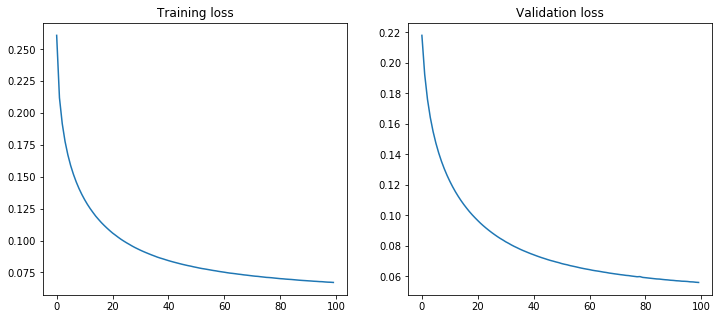

In [11]:
mlp_history = MLP.fit(c_train, ahe_target, batch_size=64, epochs=100, validation_split=0.2)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'])
plt.title('Training loss')
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['val_loss'])
plt.title('Validation loss');
MLP.save("MLP.h5")

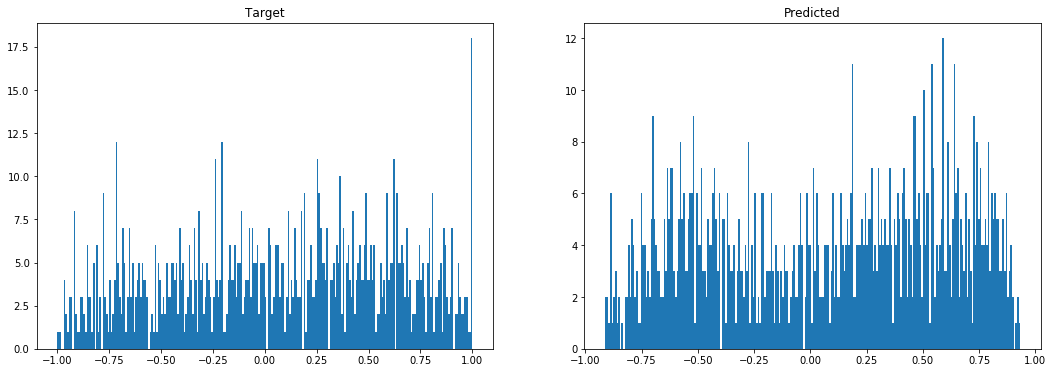

In [12]:
idx = 7
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(ahe_target[idx].ravel(),256)
plt.title('Target')
plt.subplot(1, 2, 2)
plt.hist(MLP.predict(c_train[idx:idx+1],batch_size=1)[0],256)
plt.title('Predicted')
plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 37s 913us/step - loss: 0.2858 - val_loss: 0.2840
Epoch 2/200
40000/40000 [==============================] - 41s 1ms/step - loss: 0.2726 - val_loss: 0.2490
Epoch 3/200
40000/40000 [==============================] - 36s 909us/step - loss: 0.2301 - val_loss: 0.2065
Epoch 4/200
40000/40000 [==============================] - 36s 902us/step - loss: 0.2047 - val_loss: 0.1904
Epoch 5/200
40000/40000 [==============================] - 36s 897us/step - loss: 0.1930 - val_loss: 0.1812
Epoch 6/200
40000/40000 [==============================] - 39s 964us/step - loss: 0.1849 - val_loss: 0.1745
Epoch 7/200
40000/40000 [==============================] - 36s 904us/step - loss: 0.1778 - val_loss: 0.1653
Epoch 8/200
40000/40000 [==============================] - 38s 958us/step - loss: 0.1712 - val_loss: 0.1590
Epoch 9/200
40000/40000 [==============================] - 36s 899us/step - loss: 0.1643

Epoch 76/200
40000/40000 [==============================] - 40s 989us/step - loss: 0.0732 - val_loss: 0.0637
Epoch 77/200
40000/40000 [==============================] - 36s 901us/step - loss: 0.0729 - val_loss: 0.0675
Epoch 78/200
40000/40000 [==============================] - 37s 918us/step - loss: 0.0730 - val_loss: 0.0627
Epoch 79/200
40000/40000 [==============================] - 37s 915us/step - loss: 0.0724 - val_loss: 0.0662
Epoch 80/200
40000/40000 [==============================] - 39s 973us/step - loss: 0.0722 - val_loss: 0.0624
Epoch 81/200
40000/40000 [==============================] - 36s 901us/step - loss: 0.0721 - val_loss: 0.0633
Epoch 82/200
40000/40000 [==============================] - 36s 903us/step - loss: 0.0716 - val_loss: 0.0627
Epoch 83/200
40000/40000 [==============================] - 36s 905us/step - loss: 0.0714 - val_loss: 0.0640
Epoch 84/200
40000/40000 [==============================] - 37s 920us/step - loss: 0.0714 - val_loss: 0.0622
Epoch 85/200
40000/

Epoch 151/200
40000/40000 [==============================] - 39s 981us/step - loss: 0.0610 - val_loss: 0.0515
Epoch 152/200
40000/40000 [==============================] - 39s 976us/step - loss: 0.0607 - val_loss: 0.0530
Epoch 153/200
40000/40000 [==============================] - 38s 951us/step - loss: 0.0609 - val_loss: 0.0517
Epoch 154/200
40000/40000 [==============================] - 39s 963us/step - loss: 0.0609 - val_loss: 0.0512
Epoch 155/200
40000/40000 [==============================] - 35s 870us/step - loss: 0.0604 - val_loss: 0.0554
Epoch 156/200
40000/40000 [==============================] - 36s 890us/step - loss: 0.0604 - val_loss: 0.0511
Epoch 157/200
40000/40000 [==============================] - 36s 895us/step - loss: 0.0603 - val_loss: 0.0515
Epoch 158/200
40000/40000 [==============================] - 36s 889us/step - loss: 0.0602 - val_loss: 0.0508
Epoch 159/200
40000/40000 [==============================] - 36s 901us/step - loss: 0.0600 - val_loss: 0.0502
Epoch 160/

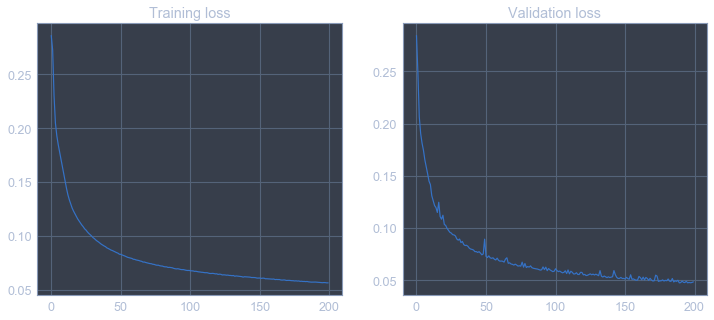

In [35]:
cnn_history = CNN.fit(c_train, ahe_target, batch_size=128, epochs=200, validation_split=0.2)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'])
plt.title('Training loss')
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['val_loss'])
plt.title('Validation loss');
CNN.save('CNN.h5')

In [13]:
#Compare CNN and MLP on histograms and mse
MLP = load_model("my_model.h5")
mlp_preds = MLP.predict(c_test)
test_hists = np.array([np.histogram(target, bins=255, density=True)[0] for target in ahe_test_target]) 
mlp_hists = np.array([np.histogram(pred, bins=255, density=True)[0] for pred in mlp_preds])
#CNN = load_model("CNN.h5")
for name, metric in [('Euclidean distance',euclidean), ('Wasserstein', wasserstein_distance)]:
    values = []
    for i in range(len(test_hists)):
        values.append(metric(mlp_hists[i], test_hists[i]))
    print("Average Histogram", name, np.mean(values))

Average Histogram Euclidean distance 9.784741956166702
Average Histogram Wasserstein 0.11700356013758474
